In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import DataLoader, Dataset ,Subset
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import glob

# Paths
DATASET_PATH = "/kaggle/input/isic2018-challenge-task1-data-segmentation"
IMAGE_DIR = os.path.join(DATASET_PATH, "ISIC2018_Task1-2_Training_Input")
MASK_DIR = os.path.join(DATASET_PATH, "ISIC2018_Task1_Training_GroundTruth")

# Use glob to get only .jpg files
image_paths = sorted(glob.glob(IMAGE_DIR + "/*.jpg"))
mask_paths = sorted(glob.glob(MASK_DIR + "/*.png"))

# Data Augmentation & Preprocessing
class SkinLesionDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L")) / 255.0  # Normalize mask to [0, 1]
        
        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask

# Define transforms for preprocessing using albumentations
transform = A.Compose([
    A.Resize(224, 224),  # Resize to 224x224 to match the Swin Transformer input size
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalization for RGB
    ToTensorV2()  # Convert to PyTorch tensor
])

# Create Dataset and DataLoader
dataset = SkinLesionDataset(image_paths, mask_paths, transform=transform)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
train_size = int(0.8 * len(dataset))
train_dataset = Subset(dataset, range(train_size))
test_dataset = Subset(dataset, range(train_size, len(dataset)))
test_loader = DataLoader(test_dataset, batch_size=1,shuffle=False)

class SwinUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(SwinUNet, self).__init__()
        self.swin_transformer = timm.create_model('swin_base_patch4_window7_224', pretrained=True)  # Pretrained Swin Transformer
        self.swin_transformer.head = nn.Identity()  # Remove the classification head
        
        # Modify the input channels for the first convolution layer
        self.conv1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)  # Change in_channels to 1024
        self.conv2 = nn.Conv2d(512, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, out_channels, kernel_size=3, padding=1)
        
        # Upsample layer to match target size (224x224)
        self.upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.swin_transformer.forward_features(x)  # Forward pass through the Swin Transformer
        x = x.permute(0, 3, 1, 2)  # Rearrange dimensions to [batch_size, channels, H, W]
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        # Upsample the output to match the target size
        x = self.upsample(x)
        return x

# Instantiate the model
model = SwinUNet()

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy for segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-5)  # Reduced learning rate

# Training Loop
def train(model, train_loader, criterion, optimizer, epochs=10, checkpoint_interval=5):
    model.train()  # Set the model to training mode

    print(f"Training started for {epochs} epochs.")
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs} started.")
        running_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            masks = masks.unsqueeze(1).float()  # Ensure masks are float and have the correct shape
            optimizer.zero_grad()  # Zero gradients

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)  # Compute loss

            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")
        running_loss = 0.0  # Reset running loss for the next epoch

        # Save a checkpoint every 'checkpoint_interval' epochs
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint = {
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch + 1
            }
            torch.save(checkpoint, f"checkpoint_epoch_{epoch + 1}.pth.tar")

    # Final checkpoint at the end of training
    checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
    torch.save(checkpoint, "checkpoint_last.pth.tar")
    print("Training complete. Final checkpoint saved.")
    
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Start training
#train(model, train_loader, criterion, optimizer, epochs=30)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [2]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    dice_score = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            dice_score += (2 * (preds * y).sum()) / (preds + y).sum() + 1e-8
            
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

In [3]:
model.load_state_dict(torch.load('/kaggle/input/checkpoint-last-cuda/checkpoint_last.pth.tar')['state_dict'])

<ipython-input-3-bfbe09d24dee>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/checkpoint-last-cuda/checkpoint_last.pth.tar'

<All keys matched successfully>

In [13]:
check_accuracy(test_loader, model, device)

Dice score: 0.9479917919105357


In [14]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import glob

# Paths for validation images and masks
validation_path = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Validation_Input"
val_img = sorted(glob.glob(validation_path + "/*.jpg"))
mask_path = r"/kaggle/input/isic2018-validation-ground-truth/ISIC2018_Task1_Validation_GroundTruth"
val_mask = sorted(glob.glob(mask_path + "/*.png"))

val_dataset = SkinLesionDataset(image_paths=validation_path,
                            mask_paths=mask_path,transform=transform)

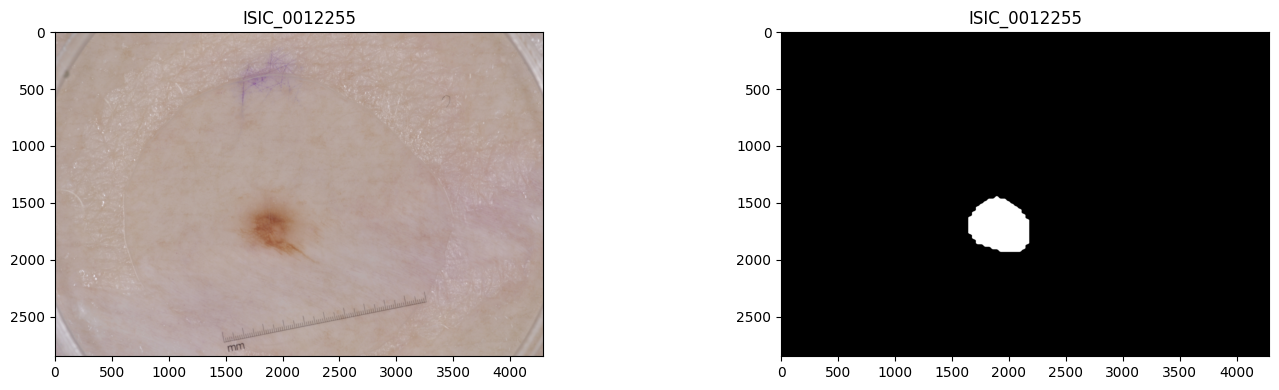

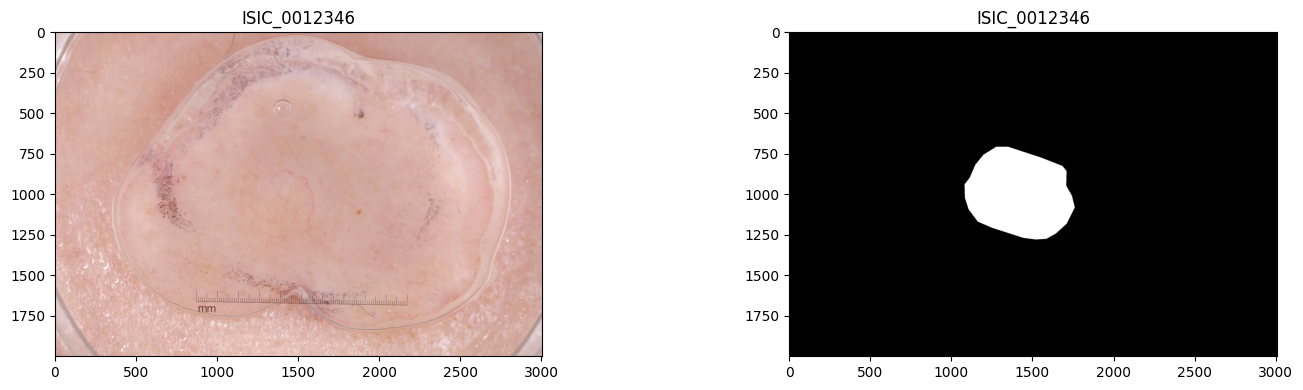

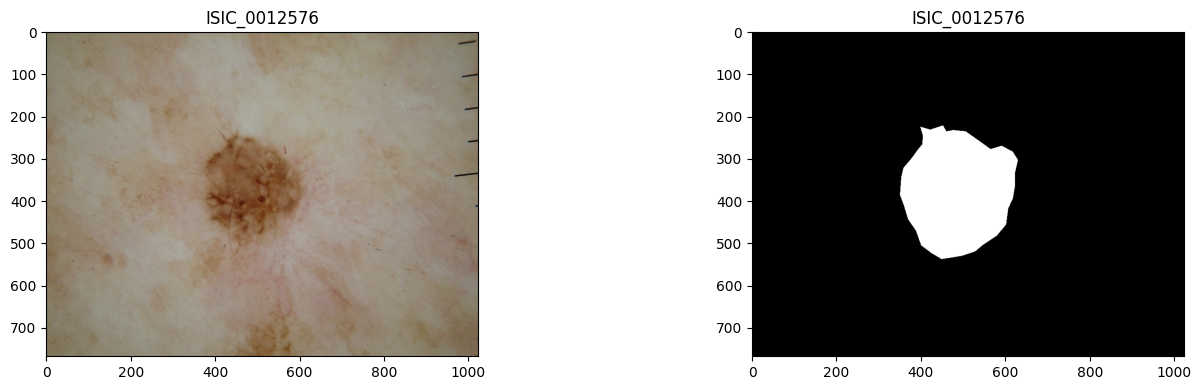

In [15]:
for i in range(3):
    samImg = cv2.imread(val_img[i])
    samMask = cv2.imread(val_mask[i])
    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.title(val_img[i].split('/')[-1].rstrip(".jpg"))
    plt.imshow(cv2.cvtColor(samImg,cv2.COLOR_BGR2RGB))
    
    plt.subplot(1,2,2)
    plt.title(val_mask[i].split('/')[-1].rstrip("_segmentation.png"))
    plt.imshow(samMask)
    plt.tight_layout()
    plt.show()

In [20]:
# Define the transformation (resize, normalization) if needed

def preprocess_image(image_path, size,device):
    # Load image with OpenCV
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB if needed

    # Resize the image if needed
    img_resized = cv2.resize(img, (size, size))

    # Convert image to float and normalize (assuming the model expects 0-1 range)
    img_resized = img_resized / 255.0

    # Convert to torch tensor and move to the specified device
    img_tensor = torch.tensor(img_resized).permute(2, 0, 1).unsqueeze(0).float().to(device)
    
    return img_tensor

In [21]:
# Initialize lists for storing metrics
imgId, dice_scores, iou_scores, sensitivities, specificities = [], [], [], [], []
size = 224

# Loop through validation images and evaluate each one
for i in range(len(val_img)):
    # Preprocess the image
    img_tensor = preprocess_image(val_img[i], size, device)
    with torch.no_grad():
        # Get predicted mask
        generated_mask = model(img_tensor).squeeze().cpu().numpy()  # Remove batch dimension and convert to numpy
    
    # Load and resize true mask for comparison
    true_mask = cv2.imread(val_mask[i], cv2.IMREAD_GRAYSCALE)
    true_mask_resized = cv2.resize(true_mask, (generated_mask.shape[1], generated_mask.shape[0]))

    # Binarize masks for metric calculations
    threshold = 0.5
    true_mask_bin = (true_mask_resized > threshold).astype(np.uint8)
    generated_mask_bin = (generated_mask > threshold).astype(np.uint8)

    # Calculate metrics (Dice, IoU, Sensitivity, Specificity)
    intersection = np.sum(true_mask_bin * generated_mask_bin)
    dice_score = (2 * intersection) / (np.sum(true_mask_bin) + np.sum(generated_mask_bin))
    dice_scores.append(dice_score)
    
    union = np.sum(true_mask_bin) + np.sum(generated_mask_bin) - intersection
    iou = intersection / union if union != 0 else 0
    iou_scores.append(iou)
    
    true_positive = np.sum((true_mask_bin == 1) & (generated_mask_bin == 1))
    false_negative = np.sum((true_mask_bin == 1) & (generated_mask_bin == 0))
    sensitivity = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
    sensitivities.append(sensitivity)
    
    true_negative = np.sum((true_mask_bin == 0) & (generated_mask_bin == 0))
    false_positive = np.sum((true_mask_bin == 0) & (generated_mask_bin == 1))
    specificity = true_negative / (true_negative + false_positive) if (true_negative + false_positive) != 0 else 0
    specificities.append(specificity)
    
    # Store image id and scores
    imgId.append(val_img[i].split('/')[-1].rstrip(".jpg"))

In [22]:
# Compile results into a DataFrame
df = pd.DataFrame({
    "img_id": imgId,
    "dice_score": dice_scores,
    "jaccard_index": iou_scores,
    "sensitivity": sensitivities,
    "specificity": specificities
})

In [23]:
print(df)

          img_id  dice_score  jaccard_index  sensitivity  specificity
0   ISIC_0012255    0.587762       0.416192     0.444580     0.998865
1   ISIC_0012346    0.343072       0.207053     1.000000     0.806524
2   ISIC_0012576    0.879675       0.785196     0.790166     0.999436
3   ISIC_0012585    0.946018       0.897566     1.000000     0.978465
4   ISIC_0012623    0.835400       0.717328     0.953895     0.914336
..           ...         ...            ...          ...          ...
95  ISIC_0036291    0.869179       0.768627     1.000000     0.949224
96  ISIC_0036306    0.865279       0.762548     0.964020     0.831893
97  ISIC_0036321    0.922846       0.856746     0.994802     0.945409
98  ISIC_0036328    0.806500       0.675743     0.998523     0.972739
99  ISIC_0036333    0.845370       0.732156     1.000000     0.968482

[100 rows x 5 columns]


In [24]:
df.to_excel("result_analysis.xlsx")

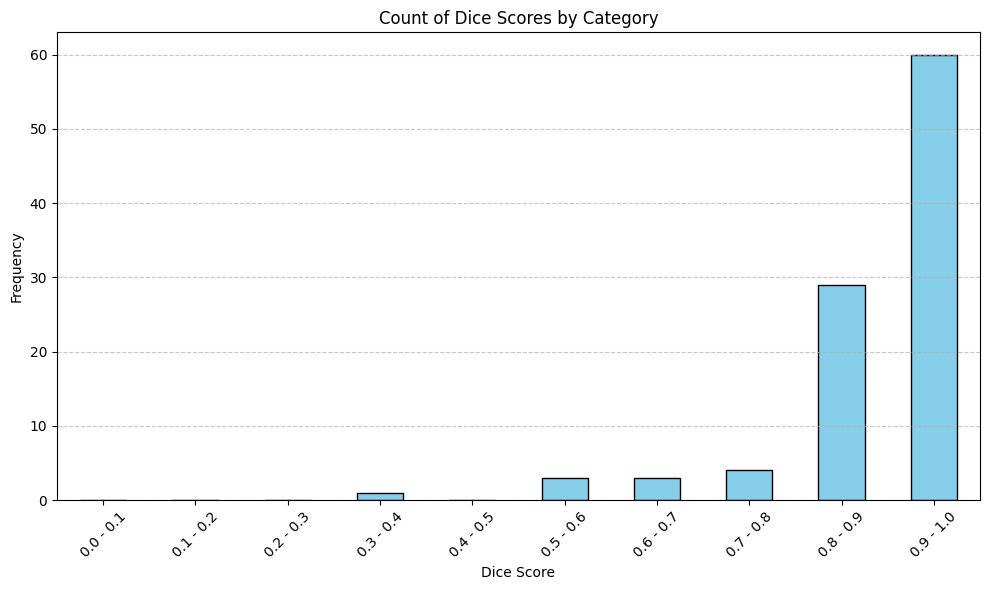

In [26]:
# Plot Dice Score Distribution
bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['0.0 - 0.1', '0.1 - 0.2', '0.2 - 0.3', '0.3 - 0.4',
          '0.4 - 0.5', '0.5 - 0.6', '0.6 - 0.7', '0.7 - 0.8',
          '0.8 - 0.9', '0.9 - 1.0']

df['Category'] = pd.cut(df['dice_score'].round(2), bins=bins, labels=labels, right=False)
category_counts = df['Category'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Count of Dice Scores by Category')
plt.xlabel('Dice Score')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

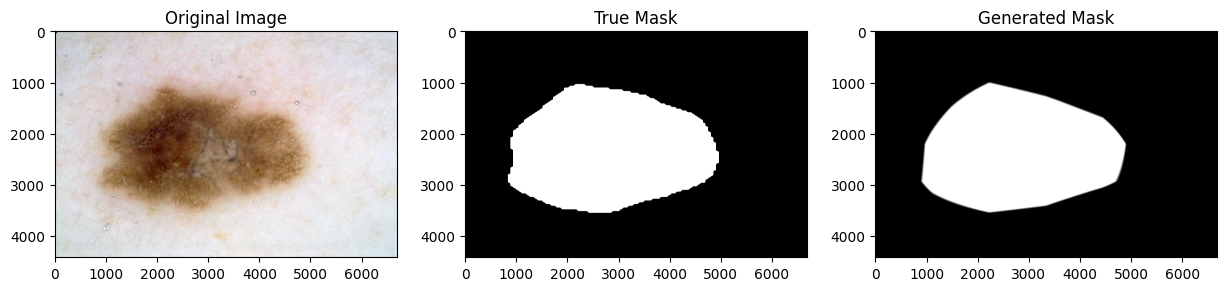

Image ID: ISIC_0015370
Dice Score: 0.9741


In [37]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

def manual_check(ind):
    # Load the image path and true mask path based on the index
    img_path = val_img[ind]
    mask_path = val_mask[ind]
    
    # Load and preprocess the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img_resized = cv2.resize(img, (size, size)) / 255.0  # Resize and normalize to 0-1
    
    # Load the true mask
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    true_mask_resized = cv2.resize(true_mask, (size, size))
    
    # Convert image to tensor and move to the device
    img_tensor = torch.tensor(img_resized).permute(2, 0, 1).unsqueeze(0).float().to(device)
    
    # Generate the mask with the model
    with torch.no_grad():
        generated_mask = model(img_tensor).squeeze().cpu().numpy()

    # Resize generated mask back to original image size for visualization
    generated_mask_resized = cv2.resize(generated_mask, (img.shape[1], img.shape[0]))
    true_mask_resized = cv2.resize(true_mask, (img.shape[1], img.shape[0]))

    # Stack the masks for visualization
    true_mask_stacked = np.stack((true_mask_resized,) * 3, axis=-1)
    generated_mask_stacked = np.stack((generated_mask_resized,) * 3, axis=-1)

    # Plot original image, true mask, and generated mask
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(img)
    ax[0].set_title('Original Image')

    ax[1].imshow(true_mask_stacked, cmap='gray')
    ax[1].set_title('True Mask')

    ax[2].imshow(generated_mask_stacked, cmap='gray')
    ax[2].set_title('Generated Mask')

    plt.show()

    # Calculate Dice Score
    threshold = 0.5
    true_mask_bin = (true_mask_resized > threshold).astype(np.uint8)
    generated_mask_bin = (generated_mask_resized > threshold).astype(np.uint8)

    intersection = np.sum(true_mask_bin * generated_mask_bin)
    dice_score = (2 * intersection) / (np.sum(true_mask_bin) + np.sum(generated_mask_bin))

    # Output image ID and Dice Score
    img_id = img_path.split('/')[-1].rstrip(".jpg")
    print(f'Image ID: {img_id}')
    print(f'Dice Score: {dice_score:.4f}')
# Provide the image index here
manual_check(10)